# Algorithms for Big Data - Exercise 10
This lecture is focused on using CNN for object localization tasks.

You can download the dataset from this course on [Github](https://github.com/rasvob/2020-21-ARD/tree/master/datasets)

[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_10.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_10.ipynb)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow as tf
# import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [2]:
import requests
from typing import List, Tuple

In [3]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# What is Object Localization?
Object localization is the name of the task of “classification with localization”. Namely, given an image, classify the object that appears in it, and find its location in the image, usually by using a bounding-box. 

In Object Localization, only a single object can appear in the image. If more than one object can appear, the task is called “Object Detection”.

![model](https://github.com/rasvob/2020-21-ARD/raw/master/images/class_vs_loc.png)

Object Localization can be treated as a regression problem - predicting a continuous value, such as a weight or a salary. For instance, we can represent our output (a bounding-box) as a tuple of size 4, as follows:

- (x,y, height, width)
    - (x,y): the coordination of the left-top corner of the bounding box
    - height: the height of the bounding box
    - width: the width of the bounding box
    
![model](https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/images/cat_bound.png)

### Network architecture in general

The coordination of the left-top corner of the bounding box must be inside the image and so do x+width and y+height. 

We will scale the image width and height to be 1.0. To make sure that the CNN outputs will be in the range [0,1], we will use the sigmoid activation layer - it will enforce that (x,y) will be inside the image, but not necessarily x+width and y+height. 

This property will be learned by the network during the training process.

![model](https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/images/loc_arch.png)

### What about the loss?

The output of a sigmoid can be treated as probabilistic values, and therefore we can use **Binary crossentropy** loss. 
You can see [this](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/binary-crossentropy) for more informations.

# We will start with purely synthetic use-case for educational purposes before we start to implement more complex one
Our task will be the detection of white circles on pure black background. We will assume that the white blobs will be located in square bounding boxes for simplicity.

In [4]:
dataset_size = 512
X = np.zeros((dataset_size, 128, 128, 1))
labels = np.zeros((dataset_size, 3))
# fill each image
for i in range(dataset_size):
    x = np.random.randint(8,120)
    y = np.random.randint(8,120)
    a = min(128 - max(x,y), min(x,y))
    r = np.random.randint(4,a)
    for x_i in range(128):
      for y_i in range(128):
        if ((x_i - x)**2) + ((y_i - y)**2) < r**2:
          X[i, x_i, y_i,:] = 1
    labels[i,0] = (x-r)/128.0
    labels[i,1] = (y-r)/128.0
    labels[i,2] = 2*r / 128.0

In [5]:
X.shape

(512, 128, 128, 1)

In [6]:
labels.shape

(512, 3)

# Single example of generated image

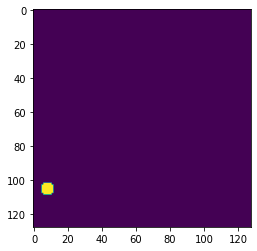

In [7]:
plt.imshow(X[0].reshape(128, 128))

In [8]:
from matplotlib.patches import Rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img.reshape(128, 128))
  rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()

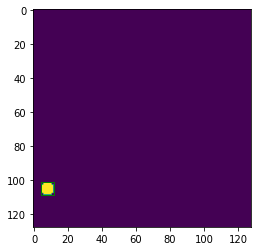

In [9]:
plot_pred(X[0], labels[0])

# More examples of our input data with bounding boxes

In [ ]:
fig, ax = plt.subplots(8, 8, figsize=(20, 14))
for i in range(8):
    for j in range(8):
        img = X[i*8 + j]
        p = labels[i*8 + j]
        ax[i, j].imshow(img.reshape(128, 128))
        rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='g',facecolor='none')
        ax[i, j].add_patch(rect)

## Let's define our first object localization model

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,1)),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(3, activation='sigmoid'),
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Fit the model on the train data.
Lets train the model on the training data and find the best model using the ModelCheckpoint callback to find the best model avaialble and achievable.

# Beware! 
## Early stopping callback probably has bug (or perhaps it is a feature, one never knows nowadays... :)) in the of weights restoration!
Early stopping restores best weights only if the training was stopped by the callback, if the training was finished it leaves the last trained weights in place.
You can see [https://github.com/keras-team/keras/issues/12511](https://github.com/keras-team/keras/issues/12511) for more detailed discussion.

Thanks go to Ondrej Chovanec who found about the issue on the internet.

## There is a possible fix involving the ModelCheckpoint so we will try this one in this lecture

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, labels, test_size=0.2, random_state=42)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 100
history = model.fit(train_x, train_y, validation_split=0.2, callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)

In [ ]:
model.evaluate(train_x, train_y)

# Now we can take a look at our predictions using the model
We can see that sometimes the prediction is slightly off but usually not by much.

In [ ]:
y_pred = model.predict(test_x)

In [ ]:
nrows = 10
fig, ax = plt.subplots(nrows, nrows, figsize=(20, 14))
for i in range(nrows):
    for j in range(nrows):
        img = test_x[i*nrows + j]
        p = test_y[i*nrows + j]
        predicted = y_pred[i*nrows + j]
        ax[i, j].imshow(img.reshape(128, 128))
        rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='g',facecolor='none')
        ax[i, j].add_patch(rect)
        rect = Rectangle(xy=(predicted[1]*128,predicted[0]*128),width=predicted[2]*128, height=predicted[2]*128, linewidth=2,edgecolor='r',facecolor='none')
        ax[i, j].add_patch(rect)

# Now we know the basics so we can focus on more realistic stuff
Usually you don't want to train your own CNN model for the task, but you try to leverage transfer learning approach. Object localization is no exception. 

Object localization/detection is very common task and there is already wide variety of the models focused on the task. 

Tensorflow 2 has very nice high-level API available for these tasks. You can use already pre-trained model which can be used directly for the inference or fine-tuned.

We will try to fine-tune the model for the object localization for which the model was not trained.

You can read the [blog post](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html) about the API or you can take a look at the [Github](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md)

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
import matplotlib

import os
import random
import io
import imageio
import glob
import scipy.misc
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


## We will start with some toy (literally) data consisting of 5 images of a rubber ducky.  

Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [ ]:
# Load images and visualize
train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
train_images_np = []
for i in range(1, 6):
  image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

## We need to anotate the images first

In [ ]:
# We can set bounding-boxes by hand but we will skip this step in the lecture
# gt_boxes = []
# colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

In [ ]:
gt_boxes = [
    np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
    np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
    np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
    np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
    np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


# Let's just visualize the rubber duckies as a sanity check


In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

If you are interested in the RetinaNet architecture, you can take a look at this [article](https://towardsdatascience.com/review-retinanet-focal-loss-object-detection-38fba6afabe4).

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

# Now we can fine-tune the model!

In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

# Load test images and run inference with new model!

In [ ]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

# Let's take a look at the result!

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))